In [1]:
from glob import glob
import sys
import os
# import psutil
from os.path import join, dirname
from os.path import getsize
import pickle
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.stats.multitest
# from statsmodels.sandbox.stats.multicomp import multipletests

# import nilearn.masking
from nilearn import plotting as nplt
from nilearn import image as niimg
import nilearn.decoding

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
# from sklearn.svm import LinearSVC

# import mydef as my Class correction for projects
import mydef

You need to connect T7SSD1 with your PC!
dir_root is replaced by /Users/clmn/Desktop/GA.


/usr/local/anaconda3/envs/sampark/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
GA = mydef.GA()

# ROI list

## Movement-related ROIs from localizer

In [ ]:
GA.initialize()

In [3]:
## ROI
path_list = sorted(glob(join(GA.dir_mask,'localizer','n200_*.nii')))
for path in path_list:
    roi = path.split('/')[-1].replace('_mask.nii', '')
    GA.roi_imgs[roi] = niimg.load_img(path)
GA.roi_imgs

{'n200_c1-1_L_M1': <nibabel.nifti1.Nifti1Image at 0x7fd339758710>,
 'n200_c1-2_L_S1': <nibabel.nifti1.Nifti1Image at 0x7fd319546690>,
 'n200_c1_L_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7fd319546710>,
 'n200_c1_R_SPL': <nibabel.nifti1.Nifti1Image at 0x7fd319546990>,
 'n200_c2_R_CerebellumIV-V': <nibabel.nifti1.Nifti1Image at 0x7fd3195466d0>,
 'n200_c2_R_MFG': <nibabel.nifti1.Nifti1Image at 0x7fd31953fd10>,
 'n200_c3_R_MTG': <nibabel.nifti1.Nifti1Image at 0x7fd31955e190>,
 'n200_c3_R_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7fd31955e3d0>,
 'n200_c4_L_IFG': <nibabel.nifti1.Nifti1Image at 0x7fd31955e610>,
 'n200_c4_L_Putamen': <nibabel.nifti1.Nifti1Image at 0x7fd31955e7d0>,
 'n200_c5_L_SPL': <nibabel.nifti1.Nifti1Image at 0x7fd31955ea10>,
 'n200_c5_R_SMA': <nibabel.nifti1.Nifti1Image at 0x7fd31955ec10>,
 'n200_c6_R_CerebellumVIIIb': <nibabel.nifti1.Nifti1Image at 0x7fd31955eb10>,
 'n200_c6_R_MFG': <nibabel.nifti1.Nifti1Image at 0x7fd31955e910>,
 'n200_c7_L_Thalamus': <nibabel

In [4]:
key_list = ['n200_c1_L_Postcentral'
            , 'n200_c2_R_CerebellumIV-V'
            , 'n200_c3_R_Postcentral'
            , 'n200_c4_L_Putamen'
            , 'n200_c5_R_SMA'
            , 'n200_c6_R_CerebellumVIIIb'
            , 'n200_c7_L_Thalamus']
temp = {}
for key in key_list:
    temp[key] = GA.roi_imgs[key]
GA.roi_imgs = temp
GA.roi_imgs

{'n200_c1_L_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7fd319546710>,
 'n200_c2_R_CerebellumIV-V': <nibabel.nifti1.Nifti1Image at 0x7fd3195466d0>,
 'n200_c3_R_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7fd31955e3d0>,
 'n200_c4_L_Putamen': <nibabel.nifti1.Nifti1Image at 0x7fd31955e7d0>,
 'n200_c5_R_SMA': <nibabel.nifti1.Nifti1Image at 0x7fd31955ec10>,
 'n200_c6_R_CerebellumVIIIb': <nibabel.nifti1.Nifti1Image at 0x7fd31955eb10>,
 'n200_c7_L_Thalamus': <nibabel.nifti1.Nifti1Image at 0x7fd3195811d0>}

### The Classification Accuracies of the above ROIs

### *Calculation
*run once

In [5]:
for subj in GA.list_subj:
# for subj in ['01', '02']:
    for stage in GA.list_stage:
        GA.cross_valid(GA.load_beta(subj, stage), GA.lda)

In [6]:
## save the result
GA.save_scores_as_pkl('7localizers')

### Wit dataframe

In [15]:
## compare by type
GA.show_pkl_list(GA.dir_script, '7localizers')

,name,identity
0,20210426_7localizers.pkl,a
1,20210511_7localizers.pkl,b


In [ ]:
## load scores
GA.load_scores_from_pkl('20210511_7localizers.pkl')

In [10]:
GA.make_wit_score()

,subj,ROI,visit,mapping,accuracy_1,accuracy_2,accuracy_3,mean_accuracy
0,01,n200_c1_L_Postcentral,early,practice,0.322917,0.427083,0.385417,0.378472
1,01,n200_c2_R_CerebellumIV-V,early,practice,0.239583,0.218750,0.322917,0.260417
2,01,n200_c3_R_Postcentral,early,practice,0.312500,0.291667,0.333333,0.312500
3,01,n200_c4_L_Putamen,early,practice,0.250000,0.322917,0.208333,0.260417
4,01,n200_c5_R_SMA,early,practice,0.333333,0.322917,0.354167,0.336806
...,...,...,...,...,...,...,...,...
835,44,n200_c3_R_Postcentral,late,unpractice,0.281250,0.322917,0.260417,0.288194
836,44,n200_c4_L_Putamen,late,unpractice,0.333333,0.322917,0.302083,0.319444
837,44,n200_c5_R_SMA,late,unpractice,0.312500,0.229167,0.208333,0.250000
838,44,n200_c6_R_CerebellumVIIIb,late,unpractice,0.343750,0.218750,0.270833,0.277778


n200_c1_L_Postcentral(n_voxles=200)
n200_c2_R_CerebellumIV-V(n_voxles=200)
n200_c3_R_Postcentral(n_voxles=200)
n200_c4_L_Putamen(n_voxles=200)
n200_c5_R_SMA(n_voxles=200)
n200_c6_R_CerebellumVIIIb(n_voxles=200)
n200_c7_L_Thalamus(n_voxles=200)


0

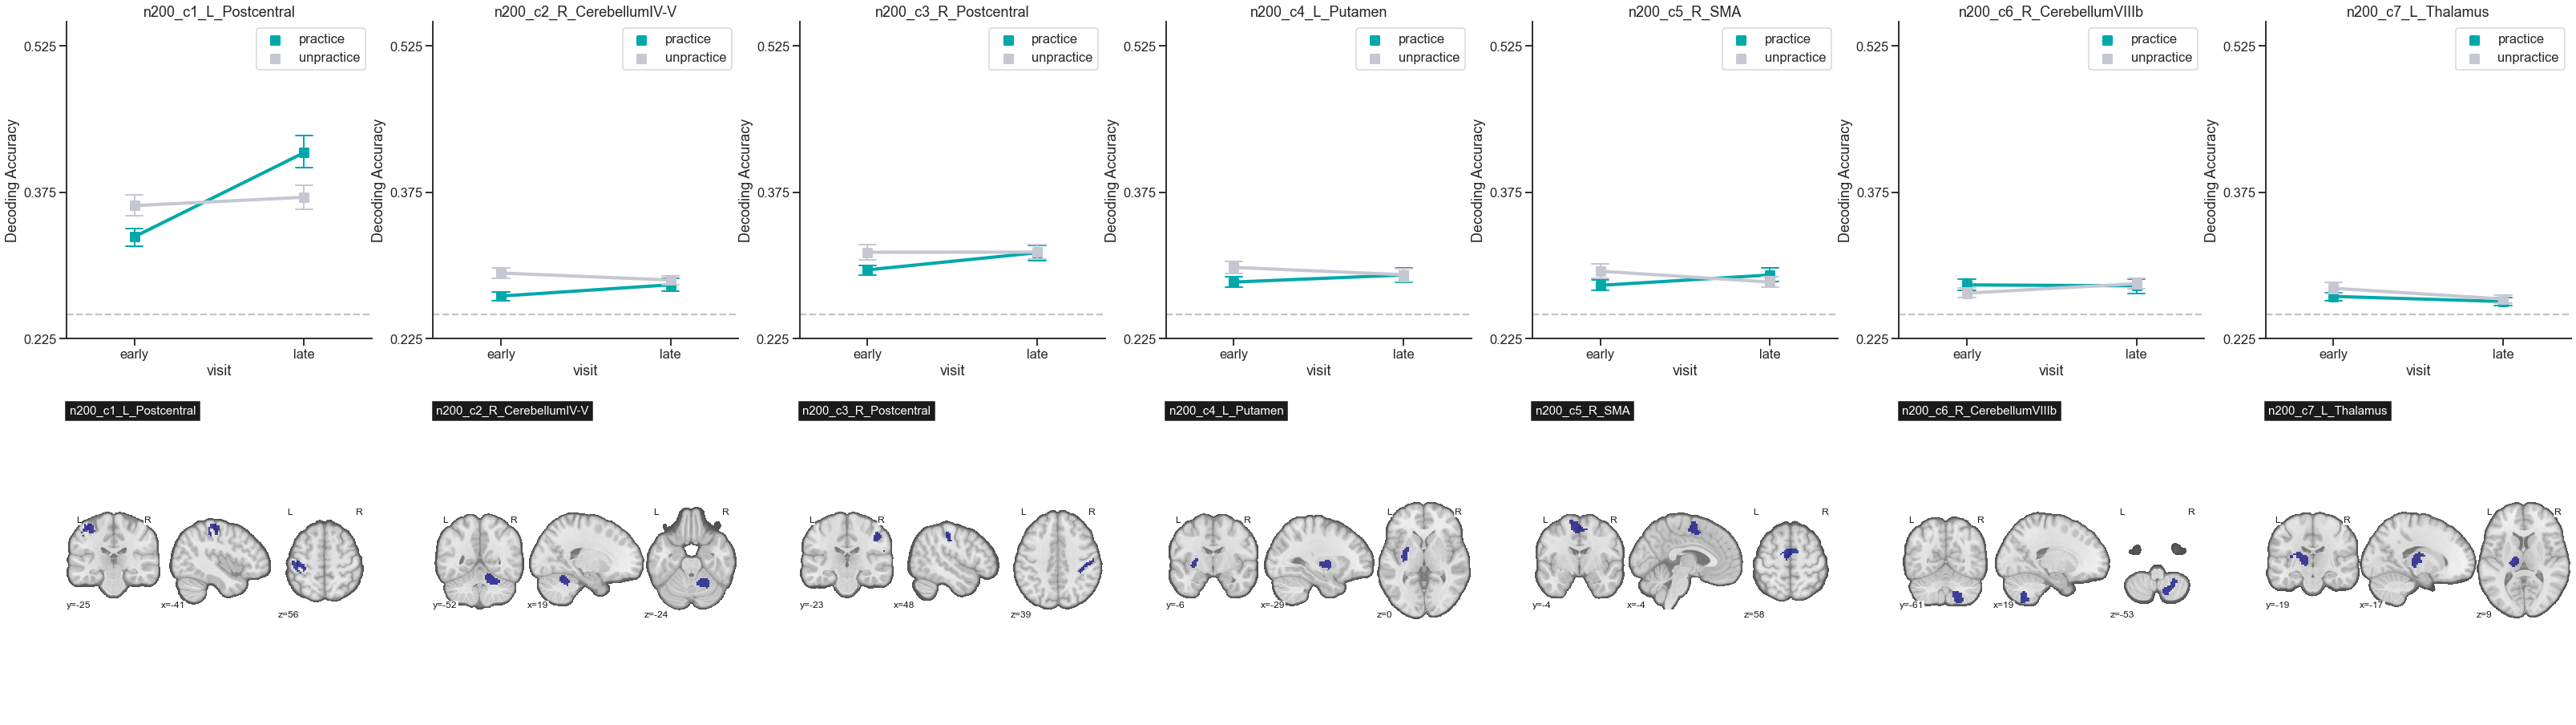

In [14]:
GA.draw_lineplots_with_rois(magnitude=8, n_columns=7, img_bg=GA.img_bg)

In [16]:
GA.do_paired_ttest('early_practice','late_practice')

,ROI,cond_A,cond_B,t-statistic,Two-sided p-value,rejected,pvalue-corrected
0,n200_c1_L_Postcentral,early_practice,late_practice,-4.574044,0.000083,True,0.000083
1,n200_c2_R_CerebellumIV-V,early_practice,late_practice,-1.865849,0.072207,False,0.072207
2,n200_c3_R_Postcentral,early_practice,late_practice,-1.926143,0.063940,False,0.063940
3,n200_c4_L_Putamen,early_practice,late_practice,-0.863909,0.394728,False,0.394728
4,n200_c5_R_SMA,early_practice,late_practice,-1.338056,0.191276,False,0.191276
5,n200_c6_R_CerebellumVIIIb,early_practice,late_practice,0.097040,0.923362,False,0.923362
6,n200_c7_L_Thalamus,early_practice,late_practice,0.832935,0.411689,False,0.411689


In [17]:
GA.do_paired_ttest('early_practice','early_unpractice')

,ROI,cond_A,cond_B,t-statistic,Two-sided p-value,rejected,pvalue-corrected
0,n200_c1_L_Postcentral,early_practice,early_unpractice,-2.810440,0.008773,False,0.008773
1,n200_c2_R_CerebellumIV-V,early_practice,early_unpractice,-3.244826,0.002959,True,0.002959
2,n200_c3_R_Postcentral,early_practice,early_unpractice,-1.859598,0.073115,False,0.073115
3,n200_c4_L_Putamen,early_practice,early_unpractice,-1.900152,0.067397,False,0.067397
4,n200_c5_R_SMA,early_practice,early_unpractice,-1.781301,0.085341,False,0.085341
5,n200_c6_R_CerebellumVIIIb,early_practice,early_unpractice,1.298888,0.204216,False,0.204216
6,n200_c7_L_Thalamus,early_practice,early_unpractice,-1.218488,0.232859,False,0.232859


In [18]:
GA.do_paired_ttest('late_practice','late_unpractice')

,ROI,cond_A,cond_B,t-statistic,Two-sided p-value,rejected,pvalue-corrected
0,n200_c1_L_Postcentral,late_practice,late_unpractice,3.154366,0.003728,True,0.003728
1,n200_c2_R_CerebellumIV-V,late_practice,late_unpractice,-0.597574,0.554762,False,0.554762
2,n200_c3_R_Postcentral,late_practice,late_unpractice,-0.074177,0.941379,False,0.941379
3,n200_c4_L_Putamen,late_practice,late_unpractice,-0.033267,0.973689,False,0.973689
4,n200_c5_R_SMA,late_practice,late_unpractice,1.001306,0.324961,False,0.324961
5,n200_c6_R_CerebellumVIIIb,late_practice,late_unpractice,-0.232368,0.817884,False,0.817884
6,n200_c7_L_Thalamus,late_practice,late_unpractice,-0.402506,0.690263,False,0.690263


In [19]:
GA.make_wit_mean_ttest(stage='early_practice', mean=0.25)

,ROI,visit,mapping,tval,pval_uncorrected,reject,pval_corrected
0,n200_c1_L_Postcentral,early,practice,8.703611,1.394858e-09,True,1.394858e-09
1,n200_c2_R_CerebellumIV-V,early,practice,3.806147,6.754291e-04,True,6.754291e-04
2,n200_c3_R_Postcentral,early,practice,9.022293,6.455393e-10,True,6.455393e-10
3,n200_c4_L_Putamen,early,practice,6.371906,5.772277e-07,True,5.772277e-07
4,n200_c5_R_SMA,early,practice,5.639728,4.297449e-06,True,4.297449e-06
5,n200_c6_R_CerebellumVIIIb,early,practice,5.129903,1.767790e-05,True,1.767790e-05
6,n200_c7_L_Thalamus,early,practice,4.464133,1.121099e-04,True,1.121099e-04


## My replicated ROIs from localizers

In [18]:
## ROI
GA.roi_imgs = {}
path_list = sorted(glob(join(GA.dir_mask,'localizer_sampark','n*.nii.gz')))
for path in path_list:
    roi = path.split('/')[-1].replace('_mask.nii', '')
    GA.roi_imgs[roi] = niimg.load_img(path)
GA.roi_imgs

{'n200.L_Thalamus.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7f84646e7c10>,
 'n200.R_CerebellumVIIIb.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7f84646e7f40>,
 'n200.R_Postcentral.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7f84646e76a0>,
 'n201.L_Postcentral.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7f84646e7250>,
 'n202.R_CerebellumIV-V.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7f84646e7ac0>,
 'n202.S_SMA.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7f8461e08df0>,
 'n225.L_Putamen.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7f84538a24c0>}

n200.L_Thalamus.nii.gz(n_voxles=200)
n200.R_CerebellumVIIIb.nii.gz(n_voxles=200)
n200.R_Postcentral.nii.gz(n_voxles=200)
n201.L_Postcentral.nii.gz(n_voxles=201)
n202.R_CerebellumIV-V.nii.gz(n_voxles=202)
n202.S_SMA.nii.gz(n_voxles=202)
n225.L_Putamen.nii.gz(n_voxles=225)


0

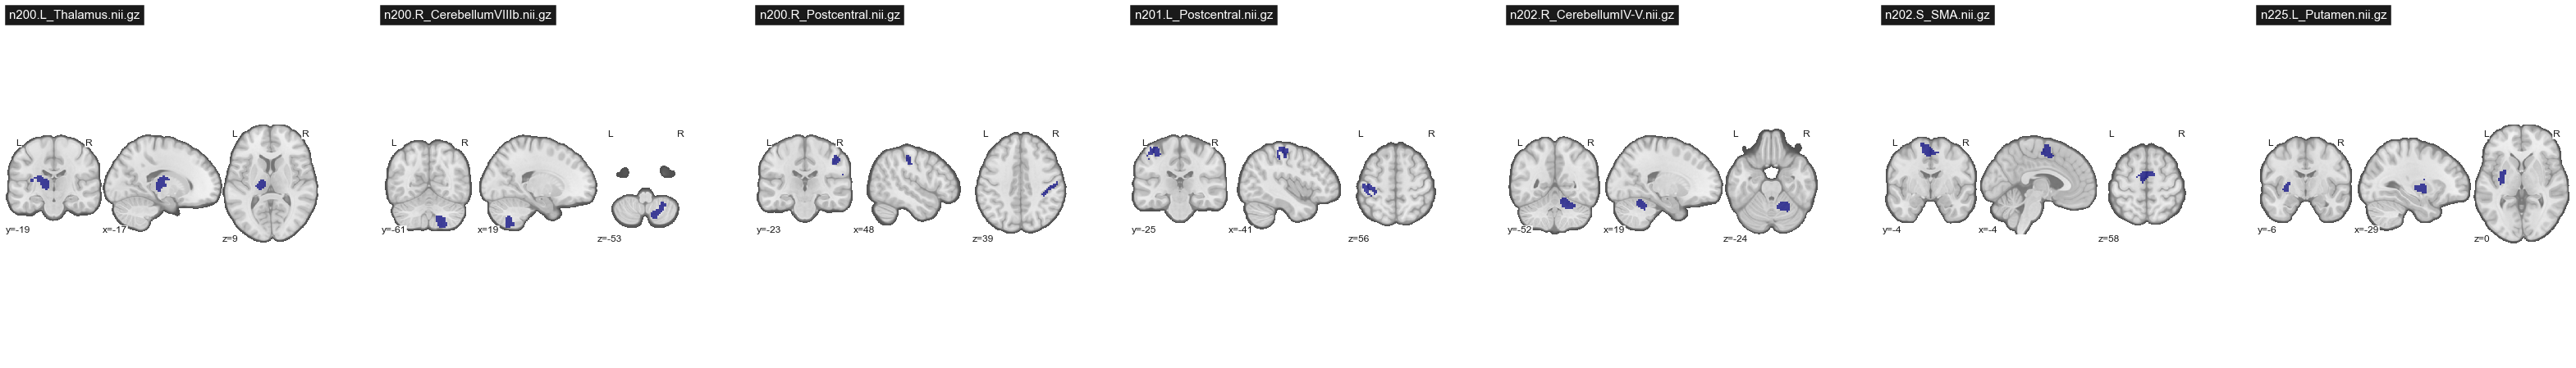

In [19]:
GA.draw_rois(magnitude=8, n_columns=7, img_bg=img_bg)

## Default Mode Network

In [22]:
GA.initialize()

In [18]:
## DMN regions(global)
module_names = ['Core', 'dMsub', 'MTLsub']

for name in module_names:
    DMN_list = glob(join(GA.dir_dmn, name+'.nii'))
    for path in DMN_list:
        fname = path.split('/')[-1].replace('.nii', '')
        GA.roi_imgs[fname] = nilearn.image.load_img(path)
        
# ## DMN regions(detail)
module_names = ['Core', 'dMsub', 'MTLsub']

for name in module_names:
    DMN_list = glob(join(GA.dir_dmn, name+'_*.nii'))
    for path in DMN_list:
        fname = path.split('/')[-1].replace('.nii', '')
        GA.roi_imgs[fname] = nilearn.image.load_img(path)

GA.roi_imgs

{'Core': <nibabel.nifti1.Nifti1Image at 0x7ff152d14c90>,
 'dMsub': <nibabel.nifti1.Nifti1Image at 0x7ff152d14950>,
 'MTLsub': <nibabel.nifti1.Nifti1Image at 0x7ff1625b7390>,
 'Core_PCC_r': <nibabel.nifti1.Nifti1Image at 0x7ff1625b7350>,
 'Core_aMPFC_l': <nibabel.nifti1.Nifti1Image at 0x7ff1625b7790>,
 'Core_PCC_l': <nibabel.nifti1.Nifti1Image at 0x7ff1625b78d0>,
 'Core_aMPFC_r': <nibabel.nifti1.Nifti1Image at 0x7ff1625b7cd0>,
 'dMsub_TempP_r_temp': <nibabel.nifti1.Nifti1Image at 0x7ff1625b7c10>,
 'dMsub_dMPFC': <nibabel.nifti1.Nifti1Image at 0x7ff1527d59d0>,
 'dMsub_TempP_l_temp': <nibabel.nifti1.Nifti1Image at 0x7ff1527d5d90>,
 'dMsub_TPJ_l': <nibabel.nifti1.Nifti1Image at 0x7ff1527d51d0>,
 'dMsub_LTC_l': <nibabel.nifti1.Nifti1Image at 0x7ff1527d5c90>,
 'dMsub_TPJ_r': <nibabel.nifti1.Nifti1Image at 0x7ff1527d5e10>,
 'dMsub_LTC_r': <nibabel.nifti1.Nifti1Image at 0x7ff1527d5590>,
 'MTLsub_HF_r': <nibabel.nifti1.Nifti1Image at 0x7ff1527d5b10>,
 'MTLsub_PHC_r': <nibabel.nifti1.Nifti1Image

### Check that the default ROIs are equal to the sum of their sub-ROIs.

In [22]:
# ## Core
# img_sum = nilearn.image.math_img(
#     formula="img1+img2+img3+img4 > 0",
#     img1=GA.roi_imgs['Core_PCC_l'], img2=GA.roi_imgs['Core_PCC_r'], img3=GA.roi_imgs['Core_aMPFC_l'], img4=GA.roi_imgs['Core_aMPFC_r']
# )
# img_res = nilearn.image.math_img(formula="img1-img2", img1=GA.roi_imgs['Core'], img2=img_sum)
# img_res.get_fdata().sum()

0.0

In [23]:
# ## MTL
# img_sum = nilearn.image.math_img(
#     formula="img1+img2+img3+img4+img5+img6+img7+img8+img9 > 0",
#     img1=GA.roi_imgs['MTLsub_HF_l'], img2=GA.roi_imgs['MTLsub_HF_r']
#     , img3=GA.roi_imgs['MTLsub_PHC_l'], img4=GA.roi_imgs['MTLsub_PHC_r']
#     , img5=GA.roi_imgs['MTLsub_Rsp_l'], img6=GA.roi_imgs['MTLsub_Rsp_r']
#     , img7=GA.roi_imgs['MTLsub_pIPL_l'], img8=GA.roi_imgs['MTLsub_pIPL_r']
#     , img9=GA.roi_imgs['MTLsub_vMPFC']
# )
# img_res = nilearn.image.math_img(formula="img1-img2", img1=GA.roi_imgs['MTLsub'], img2=img_sum)
# img_res.get_fdata().sum()

0.0

In [25]:
# ## DMPFC
# img_sum = nilearn.image.math_img(
#     formula="img1+img2+img3+img4+img5+img6+img7 > 0",
#     img1=GA.roi_imgs['dMsub_LTC_l'], img2=GA.roi_imgs['dMsub_LTC_r']
#     , img3=GA.roi_imgs['dMsub_TPJ_l'], img4=GA.roi_imgs['dMsub_TPJ_r']
#     , img5=GA.roi_imgs['dMsub_TempP_l_temp'], img6=GA.roi_imgs['dMsub_TempP_r_temp']
#     , img7=GA.roi_imgs['dMsub_dMPFC']
# )
# img_res = nilearn.image.math_img(formula="img1-img2", img1=GA.roi_imgs['dMsub'], img2=img_sum)
# img_res.get_fdata().sum()

0.0

### The Classification Accuracies of the above ROIs

### *Calculation
*run once

In [4]:
for subj in GA.list_subj:
    for stage in GA.list_stage:
        GA.cross_valid(GA.load_beta(subj, stage), GA.lda)

In [5]:
## save the result
GA.save_scores_as_pkl('DMN')

### Wit dataframe

In [19]:
## compare the results by type
GA.show_pkl_list(GA.dir_script, 'DMN')

,name,identity
0,20210426_DMN.pkl,a
1,20210511_DMN.pkl,b


In [20]:
## load scores
GA.load_scores_from_pkl('20210511_DMN.pkl')

In [21]:
GA.make_wit_score()

,subj,ROI,visit,mapping,accuracy_1,accuracy_2,accuracy_3,mean_accuracy
0,01,Core,early,practice,0.447917,0.333333,0.270833,0.350694
1,01,dMsub,early,practice,0.354167,0.260417,0.385417,0.333333
2,01,MTLsub,early,practice,0.406250,0.333333,0.302083,0.347222
3,01,Core_PCC_r,early,practice,0.364583,0.458333,0.291667,0.371528
4,01,Core_aMPFC_l,early,practice,0.354167,0.281250,0.312500,0.315972
...,...,...,...,...,...,...,...,...
2755,44,MTLsub_vMPFC,late,unpractice,0.343750,0.291667,0.281250,0.305556
2756,44,MTLsub_pIPL_l,late,unpractice,0.270833,0.250000,0.354167,0.291667
2757,44,MTLsub_HF_l,late,unpractice,0.291667,0.291667,0.302083,0.295139
2758,44,MTLsub_PHC_l,late,unpractice,0.322917,0.291667,0.281250,0.298611


Core(n_voxles=760)
dMsub(n_voxles=1166)
MTLsub(n_voxles=1766)
Core_PCC_r(n_voxles=203)
Core_aMPFC_l(n_voxles=203)
Core_PCC_l(n_voxles=203)
Core_aMPFC_r(n_voxles=203)
dMsub_TempP_r_temp(n_voxles=90)
dMsub_dMPFC(n_voxles=203)
dMsub_TempP_l_temp(n_voxles=79)
dMsub_TPJ_l(n_voxles=203)
dMsub_LTC_l(n_voxles=196)
dMsub_TPJ_r(n_voxles=202)
dMsub_LTC_r(n_voxles=193)
MTLsub_HF_r(n_voxles=203)
MTLsub_PHC_r(n_voxles=203)
MTLsub_Rsp_r(n_voxles=203)
MTLsub_pIPL_r(n_voxles=170)
MTLsub_vMPFC(n_voxles=191)
MTLsub_pIPL_l(n_voxles=187)
MTLsub_HF_l(n_voxles=203)
MTLsub_PHC_l(n_voxles=203)
MTLsub_Rsp_l(n_voxles=203)


0

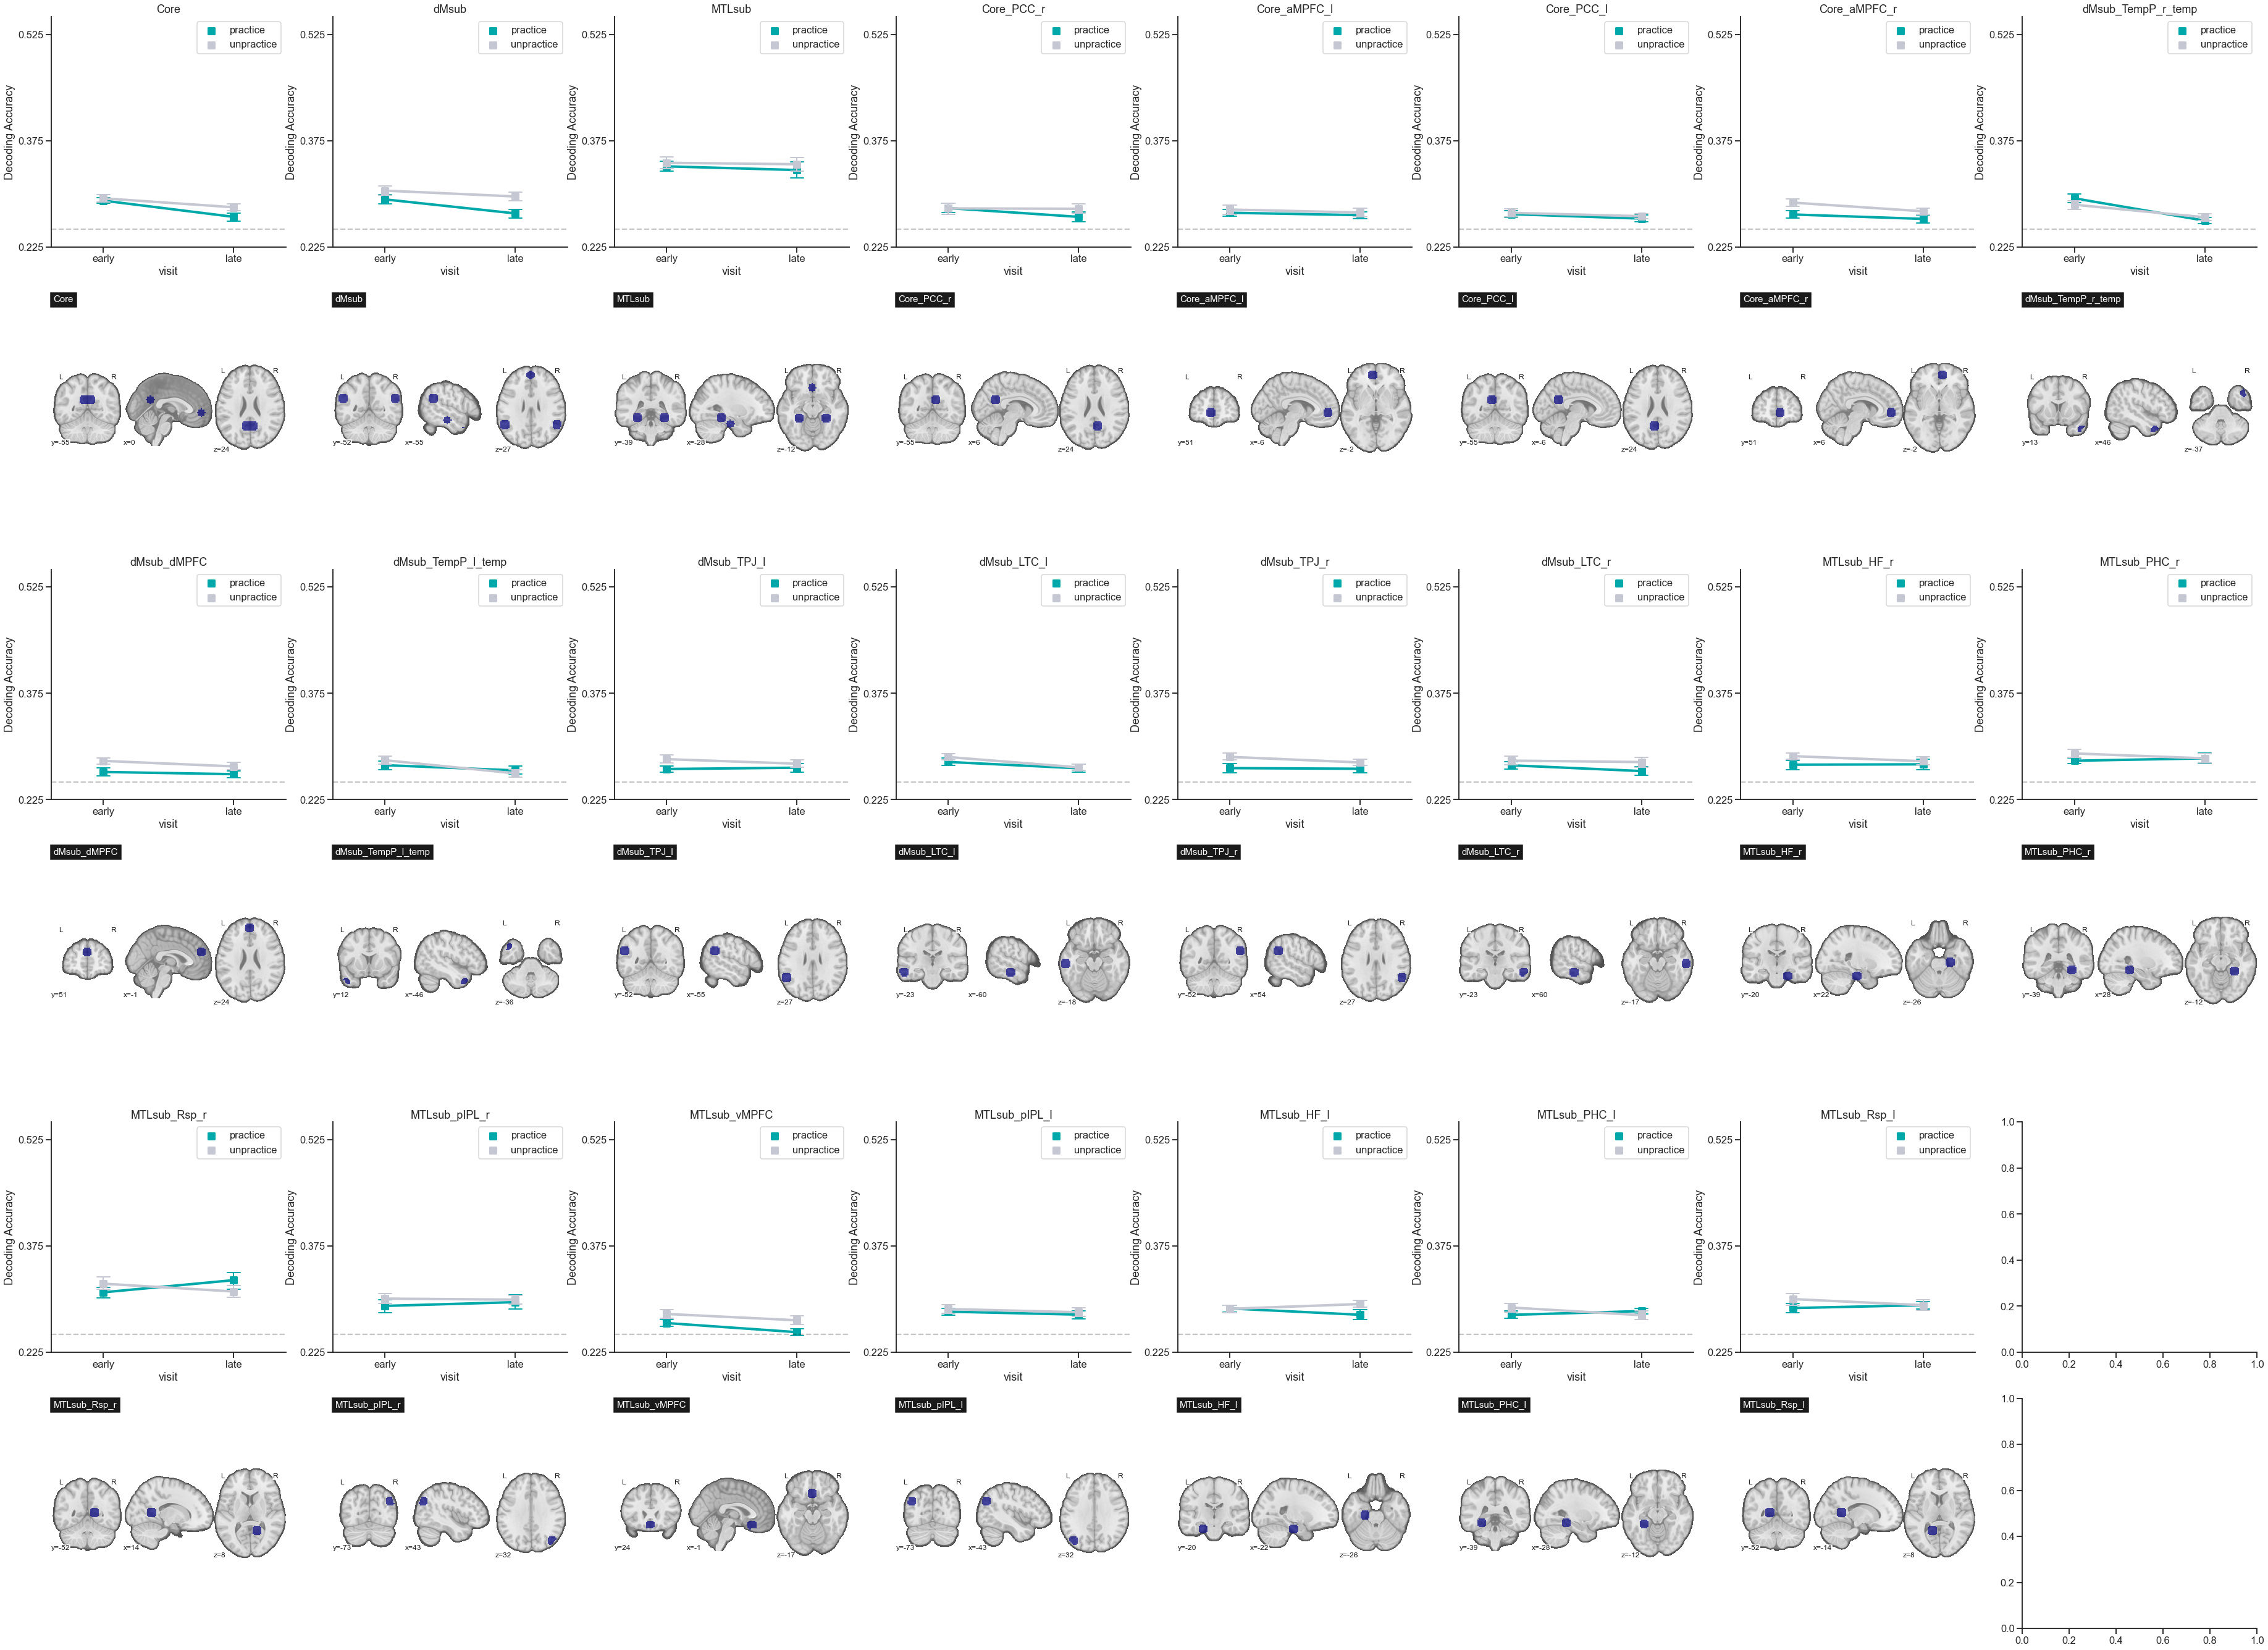

In [9]:
GA.draw_lineplots_with_rois(magnitude=8, n_columns=8, img_bg=GA.img_bg)

In [10]:
GA.make_wit_mean_ttest(stage='early_practice', mean=0.25)

,ROI,visit,mapping,tval,pval_uncorrected,reject,pval_corrected
0,Core,early,practice,9.557470,1.824209e-10,True,1.824209e-10
1,dMsub,early,practice,5.784743,2.879420e-06,True,2.879420e-06
2,MTLsub,early,practice,12.597609,2.757169e-13,True,2.757169e-13
3,Core_PCC_r,early,practice,4.341874,1.570437e-04,True,1.570437e-04
4,Core_aMPFC_l,early,practice,4.303960,1.743049e-04,True,1.743049e-04
5,Core_PCC_l,early,practice,4.362740,1.482769e-04,True,1.482769e-04
6,Core_aMPFC_r,early,practice,3.927922,4.863837e-04,True,4.863837e-04
7,dMsub_TempP_r_temp,early,practice,6.640872,2.791293e-07,True,2.791293e-07
8,dMsub_dMPFC,early,practice,2.639808,1.321310e-02,False,1.321310e-02
9,dMsub_TempP_l_temp,early,practice,3.729146,8.302560e-04,True,8.302560e-04


In [11]:
GA.make_wit_mean_ttest(stage='late_practice', mean=0.25)

,ROI,visit,mapping,tval,pval_uncorrected,reject,pval_corrected
0,Core,late,practice,3.259191,2.851428e-03,True,2.851428e-03
1,dMsub,late,practice,3.605832,1.152894e-03,True,1.152894e-03
2,MTLsub,late,practice,7.334242,4.439901e-08,True,4.439901e-08
3,Core_PCC_r,late,practice,2.409334,2.255634e-02,False,2.255634e-02
4,Core_aMPFC_l,late,practice,4.343465,1.563576e-04,True,1.563576e-04
5,Core_PCC_l,late,practice,3.032346,5.071951e-03,False,5.071951e-03
6,Core_aMPFC_r,late,practice,2.814923,8.677852e-03,False,8.677852e-03
7,dMsub_TempP_r_temp,late,practice,2.624293,1.370684e-02,False,1.370684e-02
8,dMsub_dMPFC,late,practice,2.200810,3.586352e-02,False,3.586352e-02
9,dMsub_TempP_l_temp,late,practice,3.014728,5.300587e-03,False,5.300587e-03


In [12]:
GA.make_wit_mean_ttest(stage='early_unpractice', mean=0.25)

,ROI,visit,mapping,tval,pval_uncorrected,reject,pval_corrected
0,Core,early,unpractice,7.740036,1.553432e-08,True,1.553432e-08
1,dMsub,early,unpractice,8.474080,2.449785e-09,True,2.449785e-09
2,MTLsub,early,unpractice,10.933011,8.399663e-12,True,8.399663e-12
3,Core_PCC_r,early,unpractice,3.691938,9.169841e-04,True,9.169841e-04
4,Core_aMPFC_l,early,unpractice,4.261510,1.958627e-04,True,1.958627e-04
5,Core_PCC_l,early,unpractice,3.924405,4.910333e-04,True,4.910333e-04
6,Core_aMPFC_r,early,unpractice,6.662575,2.633160e-07,True,2.633160e-07
7,dMsub_TempP_r_temp,early,unpractice,5.592703,4.894442e-06,True,4.894442e-06
8,dMsub_dMPFC,early,unpractice,6.178657,9.767903e-07,True,9.767903e-07
9,dMsub_TempP_l_temp,early,unpractice,5.463812,6.994452e-06,True,6.994452e-06


In [13]:
GA.make_wit_mean_ttest(stage='late_unpractice', mean=0.25)

,ROI,visit,mapping,tval,pval_uncorrected,reject,pval_corrected
0,Core,late,unpractice,5.967202,1.742827e-06,True,1.742827e-06
1,dMsub,late,unpractice,7.205886,6.214671e-08,True,6.214671e-08
2,MTLsub,late,unpractice,9.895958,8.362789e-11,True,8.362789e-11
3,Core_PCC_r,late,unpractice,4.383198,1.401521e-04,True,1.401521e-04
4,Core_aMPFC_l,late,unpractice,4.046538,3.525206e-04,True,3.525206e-04
5,Core_PCC_l,late,unpractice,5.210050,1.414794e-05,True,1.414794e-05
6,Core_aMPFC_r,late,unpractice,5.957458,1.790087e-06,True,1.790087e-06
7,dMsub_TempP_r_temp,late,unpractice,3.567017,1.277622e-03,True,1.277622e-03
8,dMsub_dMPFC,late,unpractice,3.947171,4.616900e-04,True,4.616900e-04
9,dMsub_TempP_l_temp,late,unpractice,2.222099,3.423734e-02,False,3.423734e-02


In [14]:
GA.do_paired_ttest('early_practice','late_practice')

,ROI,cond_A,cond_B,t-statistic,Two-sided p-value,rejected,pvalue-corrected
0,Core,early_practice,late_practice,3.047261,0.004886,True,0.004886
1,dMsub,early_practice,late_practice,2.139986,0.040898,False,0.040898
2,MTLsub,early_practice,late_practice,0.412475,0.683024,False,0.683024
3,Core_PCC_r,early_practice,late_practice,1.304728,0.202245,False,0.202245
4,Core_aMPFC_l,early_practice,late_practice,0.494325,0.624801,False,0.624801
5,Core_PCC_l,early_practice,late_practice,0.887490,0.382117,False,0.382117
6,Core_aMPFC_r,early_practice,late_practice,0.985765,0.332402,False,0.332402
7,dMsub_TempP_r_temp,early_practice,late_practice,4.239094,0.000208,True,0.000208
8,dMsub_dMPFC,early_practice,late_practice,0.528320,0.601297,False,0.601297
9,dMsub_TempP_l_temp,early_practice,late_practice,0.882722,0.384646,False,0.384646


## Ventral visual stream (TT_Daemon, Brodmann Area)

In [10]:
GA.initialize()

In [3]:
path_list = glob(join(GA.dir_mask, 'TT_Daemon', '*.brik1.BA???.*.nii.gz'))
for path in path_list:
    temp = path.split('/')[-1].replace('.nii.gz', '')
    fname = temp.split('.')[2]
    GA.roi_imgs[fname] = nilearn.image.load_img(path)
GA.roi_imgs

{'BA19L': <nibabel.nifti1.Nifti1Image at 0x7ff170e54850>,
 'BA37R': <nibabel.nifti1.Nifti1Image at 0x7ff151bb70d0>,
 'BA18L': <nibabel.nifti1.Nifti1Image at 0x7ff151bb7490>,
 'BA17R': <nibabel.nifti1.Nifti1Image at 0x7ff151bb0350>,
 'BA19R': <nibabel.nifti1.Nifti1Image at 0x7ff151bb0510>,
 'BA18R': <nibabel.nifti1.Nifti1Image at 0x7ff151bb0790>,
 'BA38L': <nibabel.nifti1.Nifti1Image at 0x7ff151bb0a10>,
 'BA38R': <nibabel.nifti1.Nifti1Image at 0x7ff151bb0c90>,
 'BA20L': <nibabel.nifti1.Nifti1Image at 0x7ff151bbb150>,
 'BA17L': <nibabel.nifti1.Nifti1Image at 0x7ff151bbb050>,
 'BA20R': <nibabel.nifti1.Nifti1Image at 0x7ff151bbb390>,
 'BA37L': <nibabel.nifti1.Nifti1Image at 0x7ff151bbb610>}

## Fan280

In [ ]:
GA.initialize()

In [35]:
GA.load_fan()

## correlation plot

In [3]:
GA.initialize()
GA.load_fan()

In [4]:
## DMN regions(global)
module_names = ['Core']

for name in module_names:
    temp = glob(join(GA.dir_dmn, name+'.nii'))
    for path in temp:
        fname = path.split('/')[-1].replace('.nii', '')
        GA.roi_imgs[fname] = nilearn.image.load_img(path)

In [5]:
## yeo_17network == 1
dt = pd.DataFrame()
for nn in [1]:
    dt = dt.append(GA.fan_info[(GA.fan_info.yeo_17network == nn)])
for idx in dt.index:
    nn = dt.loc[idx,'label']
    region = dt.loc[idx,'region']
    GA.roi_imgs[region] = GA.fan_imgs[str(nn)]

In [6]:
def merge_fan_rois(Yeo_Network=False, Sub_Region=False):
    ## Yeo_Network : integer
    ## Sub_Region : string
    GA.load_fan()
    dt = pd.DataFrame()
    if Yeo_Network:
        for nn in Yeo_Network:
            dt = dt.append(GA.fan_info[(GA.fan_info.yeo_17network == nn)])
    elif Sub_Region:
        for ss in Sub_Region:
            dt = dt.append(GA.fan_info[(GA.fan_info.subregion_name == ss)])
    temp = {}
    for idx in dt.index:
        nn = dt.loc[idx,'label']
        region = dt.loc[idx,'region']
        temp[region] = GA.fan_imgs[str(nn)]
    ## merging
    img0 = nilearn.image.math_img(img1=GA.fan_imgs['001'], formula="img1*0")
    for _, img in temp.items():
        img0 = nilearn.image.math_img(img1=img0, img2=img, formula="(img1+img2) > 0")

    return img0

In [7]:
## merging visual region

### yeo_17network == 1
GA.roi_imgs['yeo_17network_1'] = merge_fan_rois(Yeo_Network=[1])

### yeo_17network == 2
# GA.roi_imgs['yeo_17network_2'] = merge_fan_rois(Yeo_Network=[2])

### yeo_17network == 1 or 2
# GA.roi_imgs['yeo_17network_1+2'] = merge_fan_rois(Yeo_Network=[1,2])

### subregion_name == 'V5/MT+'
# GA.roi_imgs['V5/MT'] = merge_fan_rois(Sub_Region=['V5/MT+'])

### *Calculation
*run once

In [12]:
for subj in GA.list_subj:
    for stage in GA.list_stage:
        GA.cross_valid(GA.load_beta(subj, stage), GA.lda)

In [13]:
## save the result
GA.save_scores_as_pkl('Yeo1-DMN')

### Wit dataframe

In [8]:
## compare the results by type
GA.show_pkl_list(GA.dir_script, 'Yeo1-DMN')

,name,identity
0,20210511_Yeo1-DMN.pkl,a


In [8]:
## load scores
GA.load_scores_from_pkl('20210511_Yeo1-DMN.pkl')

In [9]:
GA.make_wit_score()

,subj,ROI,visit,mapping,accuracy_1,accuracy_2,accuracy_3,mean_accuracy
0,01,Core,early,practice,0.447917,0.333333,0.270833,0.350694
1,01,FuG_L_3_2,early,practice,0.510417,0.500000,0.572917,0.527778
2,01,FuG_R_3_2,early,practice,0.447917,0.500000,0.468750,0.472222
3,01,MVOcC_L_5_1,early,practice,0.666667,0.687500,0.625000,0.659722
4,01,MVOcC_R_5_1,early,practice,0.583333,0.656250,0.583333,0.607639
...,...,...,...,...,...,...,...,...
1915,44,LOcC_R_4_3,late,unpractice,0.718750,0.687500,0.343750,0.583333
1916,44,LOcC_L_4_4,late,unpractice,0.635417,0.645833,0.354167,0.545139
1917,44,LOcC_R_4_4,late,unpractice,0.583333,0.677083,0.333333,0.531250
1918,44,LOcC_L_2_2,late,unpractice,0.531250,0.468750,0.375000,0.458333


Core(n_voxles=760)
FuG_L_3_2(n_voxles=348)
FuG_R_3_2(n_voxles=317)
MVOcC_L_5_1(n_voxles=207)
MVOcC_R_5_1(n_voxles=247)
MVOcC_L_5_3(n_voxles=259)
MVOcC_R_5_3(n_voxles=222)
MVOcC_R_5_4(n_voxles=366)
LOcC_L_4_1(n_voxles=334)
LOcC_R_4_1(n_voxles=336)
LOcC_L_4_3(n_voxles=396)
LOcC_R_4_3(n_voxles=422)
LOcC_L_4_4(n_voxles=460)
LOcC_R_4_4(n_voxles=383)
LOcC_L_2_2(n_voxles=238)
yeo_17network_1(n_voxles=4535)


0

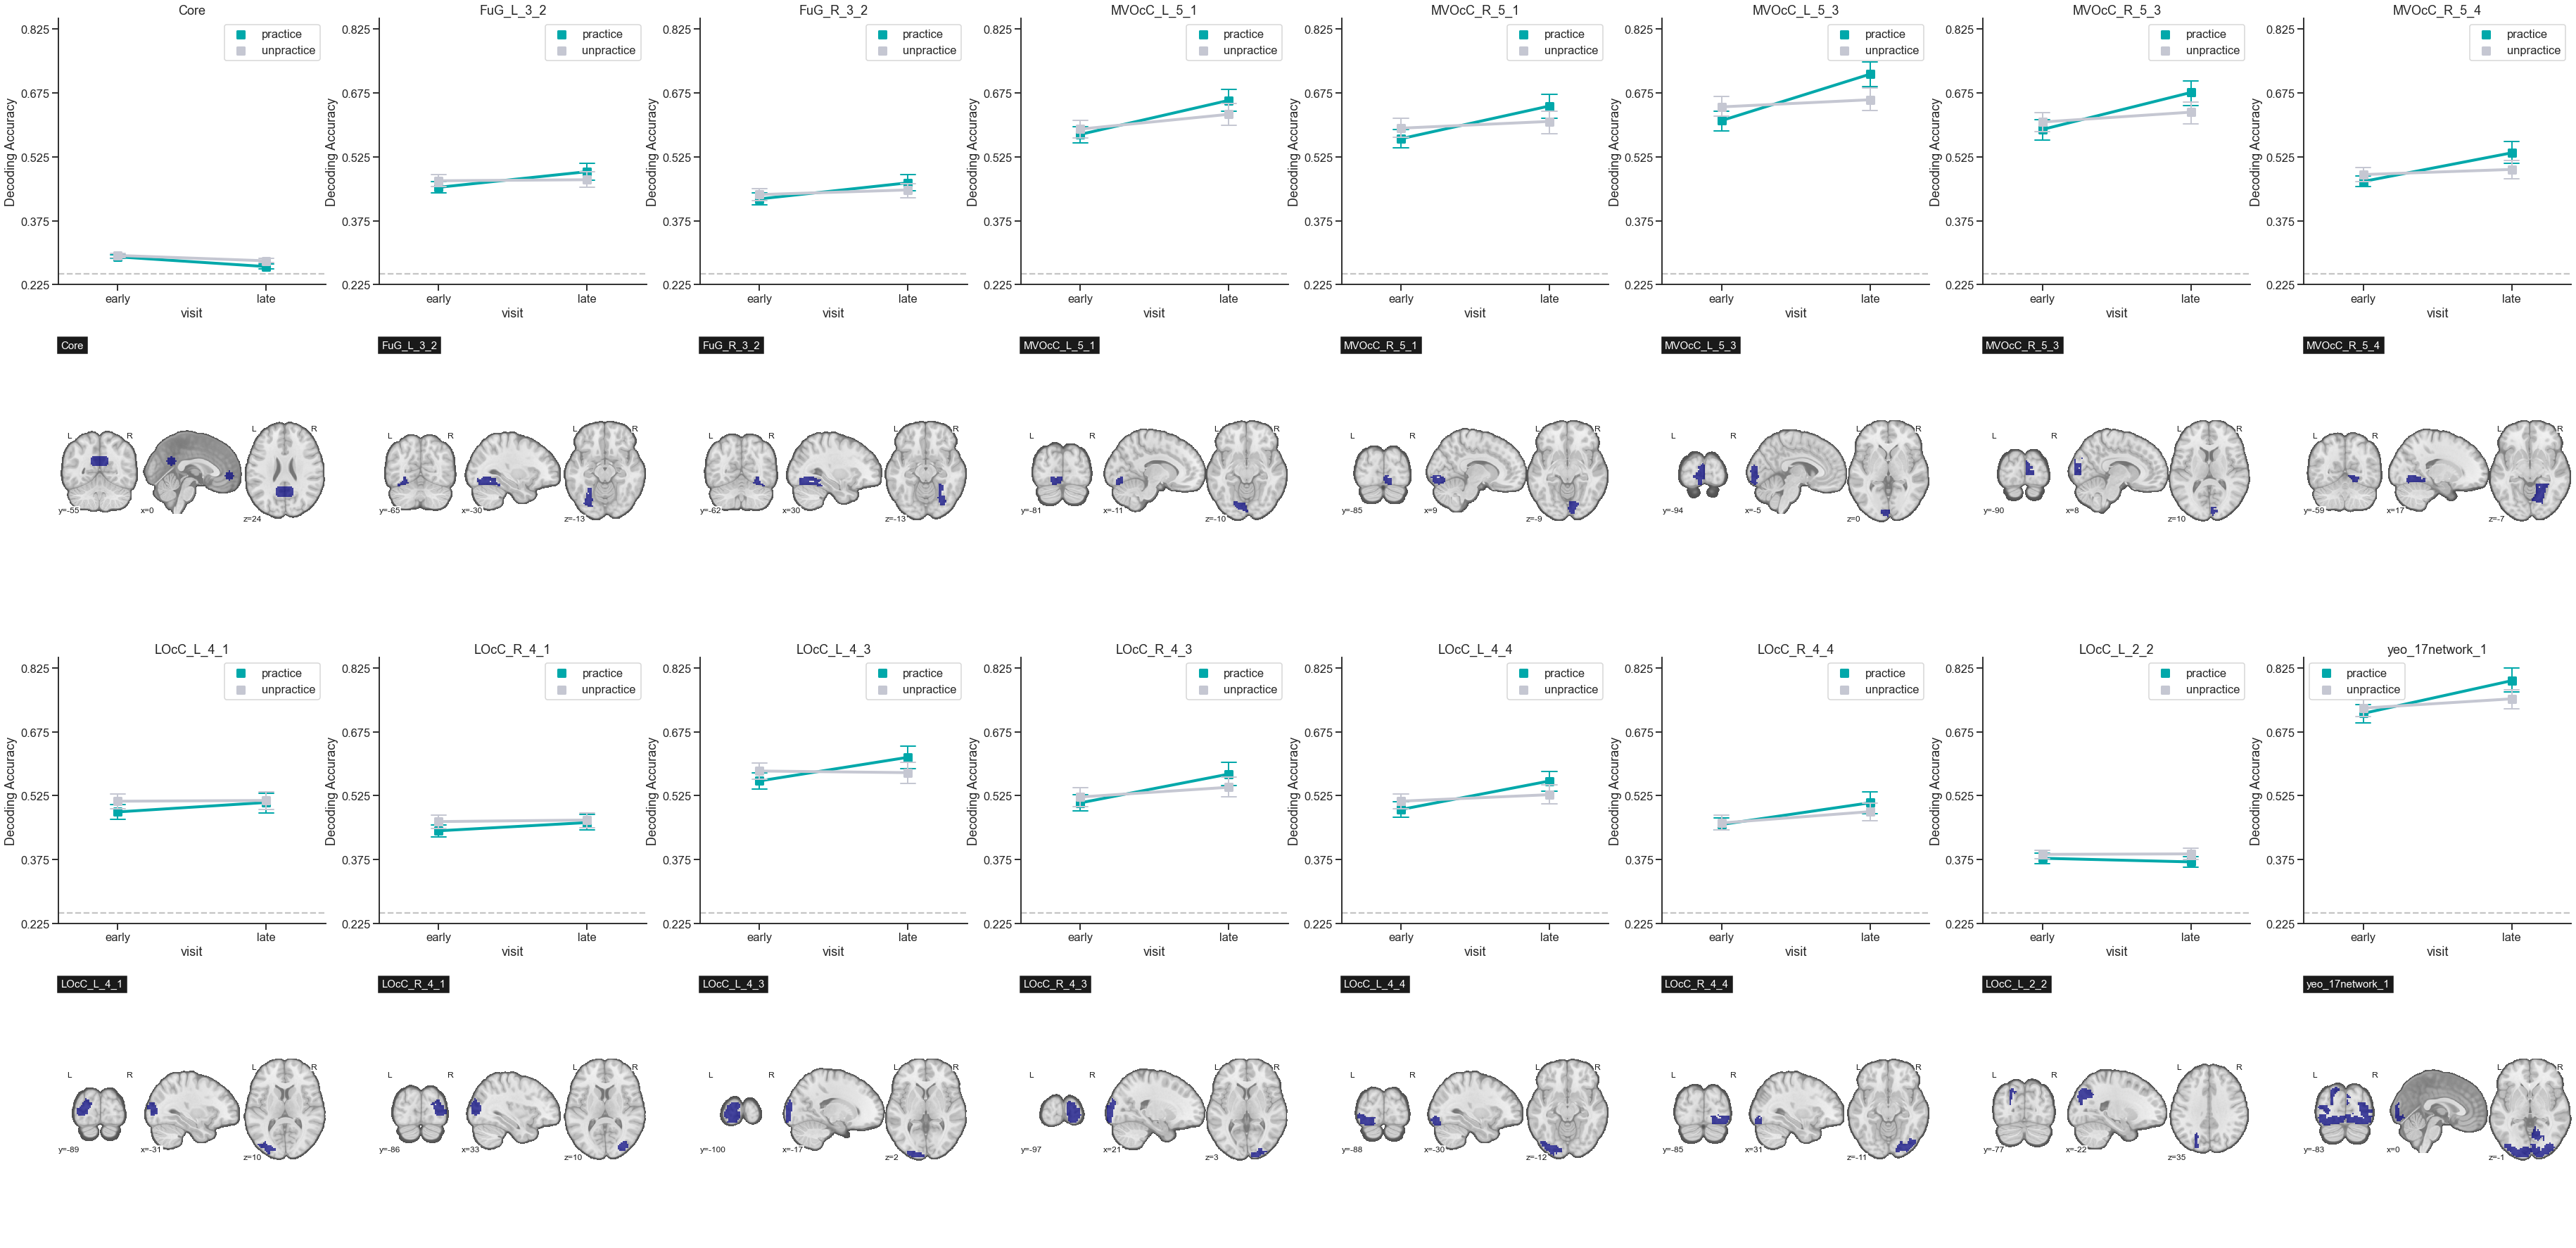

In [17]:
GA.draw_lineplots_with_rois(magnitude=8, n_columns=8, img_bg=GA.img_bg, ylim=[.225, .85])

Core(n_voxles=760)
yeo_17network_1(n_voxles=4535)


0

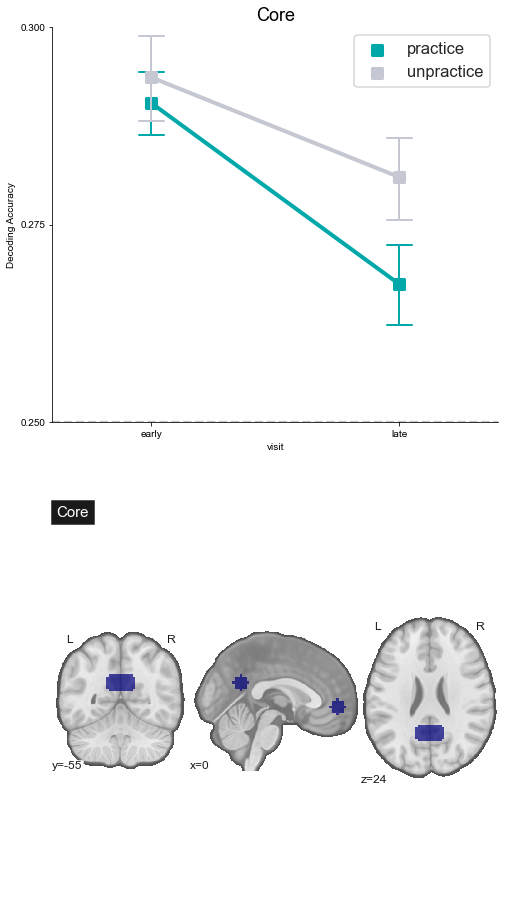

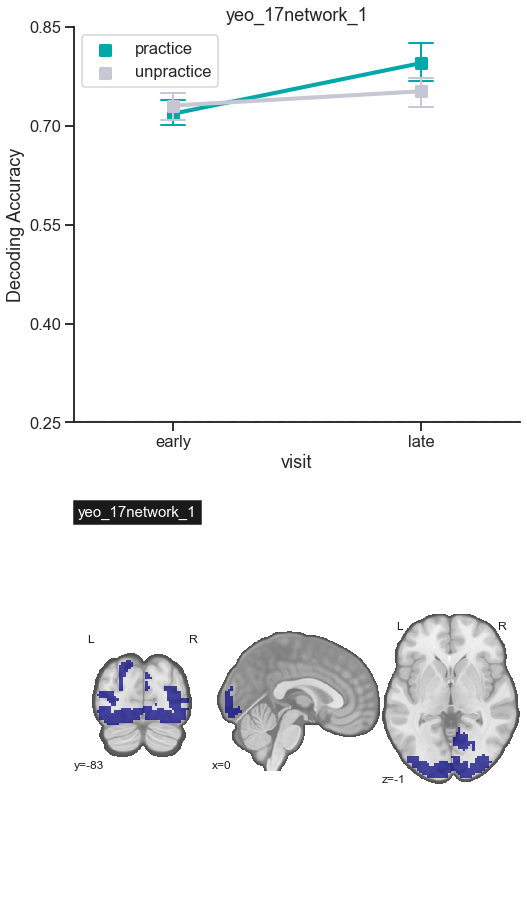

In [10]:
GA.draw_lineplot_with_roi(magnitude=8, roi_name='Core', img_bg=GA.img_bg, ylim=[.25,.30], dy=.025)
GA.draw_lineplot_with_roi(magnitude=8, roi_name='yeo_17network_1', img_bg=GA.img_bg, ylim=[.25,.85], dy=.15)

In [36]:
subj = '01'
run = 'r01'
visit = 'early'
gg = 'GA' if visit=='early' else ('GB' if visit=='late' else 'invalid')

In [43]:
for ii, run in enumerate(['r01','r02','r03']):
    ## load betas
    beta = niimg.load_img(join(GA.dir_LSS,subj,'betasLSS.%s.%s.nii.gz'%(gg+subj,run)))
    ## We suppose to exclude the first slice from the last dimension of this 4D-image
    temp = niimg.index_img(beta, np.arange(1, 97))
    if ii > 0:
        img = niimg.concat_imgs([img, temp])
    else:
        img = temp

In [44]:
img.shape

(72, 85, 72, 288)

In [47]:
roi = GA.roi_imgs['Core']

In [48]:
X = GA.fast_masking(img=img, roi=roi)

In [49]:
X.shape

(288, 760)

In [51]:
Xbar = np.mean(X, axis=1)

In [ ]:
def integration(rois, mapping):
    res = []
    
    for i, from_roi in enumerate(rois):
        for j, to_roi in enumerate(rois[(i+1):]):
            res.append(del_score[mapping, (*sorted((from_roi, to_roi)),)])

    return np.mean(res, axis=0)

In [ ]:
def interaction(rois_1, rois_2, mapping):
    res = []
    
    for i, from_roi in enumerate(rois_1):
        for j, to_roi in enumerate(rois_2):
            res.append(del_score[mapping, (*sorted((from_roi, to_roi)),)])
            
    return np.mean(res, axis=0)

In [ ]:
def draw_scatter(x, x_label):
    plt.figure(figsize=(5, 5))
    y = del_RR
    df = pd.DataFrame([y, x])
    df = df.transpose()
    df.columns = ['reward', 'x']
    sns.regplot(data=df, x='x', y='reward', ci=68)
    plt.ylabel('Reward GB-GA')
    plt.xlabel('%s GB-GA'%x_label)
    plt.title('r=%.4f (p=%.3f)' % (*scipy.stats.pearsonr(x=x, y=y),))
    #plt.xlim(-0.65, 0.65)
    plt.ylim(-0., 0.8)
    plt.show()

In [ ]:
def draw_integration(rois, x_label):
    x = integration(rois, mapping='practiced')
    draw_scatter(x, x_label)
    
def draw_interaction(rois1, rois2, x_label):
    x = interaction(rois1, rois2, mapping='practiced')
    draw_scatter(x, x_label)

In [ ]:
draw_interaction(rois1=roi_dmn, rois2=roi_vis, x_label='DMN-Visual Interaction')

# Searchlight